## Target

We want to do a book recommendation system based on the data we have cleaned before.
They are three types of recommender system:
* Collaborative filtering:This system matches persons with similar interests and provides recommendations based on this matching. It needs the historical activity of the users which we have.In the case of algorithm using similarity like KNN, it can be user-based or item-based. In the first, we recommend items to a user that similar users have also liked. In the second, we recommend items based on the past ratings of similiar items by the user.

* Content base systems: They suggest similar items based on a particular item. This system uses item metadata. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it. 

The only metadata we have about the books in our dataset is the title, author and country wich is very little. A good metadata is the genres or the summary that sadly we haven't. This method is also computationally expensive. For this reasons, we only do collaborative filtering.

We want to predict the rating given by a user to a book based on the book that he has already read and the books of user that have like the same books i.e similar users

# Loading the data previously cleaned

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
path="D:/Workspace_Python/MLProject/MachineLearningDSTIProject/dataset/"
file="final_dataset.csv"
users_csv="cleaned_users.csv"
books_csv="cleaned_books.csv"
ratings_csv="cleaned_ratings.csv"

In [4]:
books = pd.read_csv(path+books_csv, sep=";",on_bad_lines='warn', encoding="latin-1")
books.bookId.max()

248251

## Choice of the algorithm

We use the library surprise to do the recommender system. It's a library specialised in this kind of machine learning. Sadly we could not use the age nor the location with this library as only 4 columns are allowed: user, item, rating and timestamp. The age and location could have been usefull to better determine the similitude between two users or items in the case of algorithm using similitude like KNN.

We load the data into the data structure of the surprise library. For memory concern, we reduce the data to user having rated more than 5 books and book that have been rated more than 10 times

In [5]:
# Loads Pandas dataframe
from surprise import Dataset
from surprise import Reader
#we reduce the size of the dataset by removing the user that rated less than 10 books and books 
#that have been rated less than 100 times
df = pd.read_csv(path+file, sep=";",on_bad_lines='warn', encoding="latin-1")
df=df[df.userID.isin(df.userID.value_counts()[df.userID.value_counts()>5].index)][['userID','bookId','bookRating']]
df=df[df.bookId.isin(df.bookId.value_counts()[df.bookId.value_counts()>30].index)][['userID','bookId','bookRating']]
data = Dataset.load_from_df(df[['userID','bookId','bookRating']], Reader(line_format='user item rating', sep=";",rating_scale=(1, 10)))
len(df.bookId.unique())

806

In [6]:
##to see what is in the built in data of surprise
d=pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
d.head()

,user_id,item_id,rating,timestamp
0,99,97,8.0,None
1,99,102,10.0,None
2,99,103,3.0,None
3,114,119,10.0,None
4,114,115,9.0,None


We benchmark the different models by using a cross validation after having set the the seed of the RNG to have reproducible experiments. We use RMSE to measure the performance.

In [7]:
import random
import numpy as np

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

In [8]:
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from surprise.model_selection import cross_validate
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(verbose =False), SVDpp(verbose =False), SlopeOne(), KNNBaseline(verbose =False), KNNBasic(verbose =False), KNNWithMeans(verbose =False), KNNWithZScore(verbose =False), BaselineOnly(verbose =False), CoClustering(verbose =False)]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.592888,0.606456,0.103977
BaselineOnly,1.594112,0.139536,0.055115
SVDpp,1.604308,1.510418,0.362832
KNNBaseline,1.688640,1.575745,1.009205
CoClustering,1.709618,1.942767,0.085813
KNNWithMeans,1.755192,1.656067,0.967262
KNNWithZScore,1.760181,1.914319,0.964448
KNNBasic,1.778996,1.447008,0.883605
SlopeOne,1.862809,0.188598,0.201394


BaselineOnly and SVD give us the best although BaselineOnly also give us the best time, so it' is one of this two we should use. As KNNBseline can be configured by using similitude we also futher test it with both user_based and item_based configuration.  

## Hyper_tuning of BaseLineOnly

In [9]:
from surprise.model_selection import GridSearchCV
bsl_options = {"method": ["als"], "n_epochs": [10,15,20,25 ], "reg_u": [4,5,10,15,20], "reg_i": [5,10,15,20]}
param_grid={"bsl_options":bsl_options}
gs = GridSearchCV(BaselineOnly, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
best_param_bsl=gs.best_params["rmse"]
print(best_param_bsl)

1.5611580885598726
{'bsl_options': {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 10}}


## Hyper tuning of SVD

In [10]:
param_grid = {"n_epochs": [15,20,25,30],"lr_all": [0.004,0.008,0.01,0.02],"reg_all": [0,0.02,0.4,0.5, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
best_param_svd=gs.best_params["rmse"]
print(best_param_svd)

1.5707155442130396
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.4}


## Hyper tuning of KNNBaseLine 

In [11]:
""""bsl_options = {"method": ["als"], "n_epochs": [15,20,25 ], "reg_u": [2,5,8,10], "reg_i": [2,4,6]}
sim_options = {"name": ["cosine"],"user_based": [True,False]}
param_grid = {"bsl_options":bsl_options, "sim_options":sim_options, "k":[20,40,60]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])"""

'"bsl_options = {"method": ["als"], "n_epochs": [15,20,25 ], "reg_u": [2,5,8,10], "reg_i": [2,4,6]}\nsim_options = {"name": ["cosine"],"user_based": [True,False]}\nparam_grid = {"bsl_options":bsl_options, "sim_options":sim_options, "k":[20,40,60]}\ngs = GridSearchCV(KNNBaseline, param_grid, measures=["rmse", "mae"], cv=5,n_jobs =2, joblib_verbose=0)\ngs.fit(data)\n\nprint(gs.best_score["rmse"])\nprint(gs.best_params["rmse"])'

# Training of the model

The benchmark and the tunning of the model show that the best model is the BaseLineOnly with the Alternating Least Squares procedure configured with 25 iterations,reg_u=4 and reg_i=10 

In [16]:
from surprise.model_selection import train_test_split
from surprise import accuracy
bsl_options= {'method': 'als', 'n_epochs': 25, 'reg_u': 4, 'reg_i': 10}
trainset_bsl, testset_bsl = train_test_split(data, test_size=0.25)
#trainset_bsl = data.build_full_trainset()
algo_bsl = BaselineOnly(bsl_options=bsl_options,verbose =False)
algo_bsl.fit(trainset_bsl)

In [17]:
trainset_svd, testset_svd = train_test_split(data, test_size=0.25)
#trainset_svd = data.build_full_trainset()
algo_svd=SVD(n_epochs= 30, lr_all= 0.01, reg_all= 0.4)
algo_svd.fit(trainset_svd)

To get the 5 best recommendation ofr each user we could use the method get_top_n provided by surprise:

In [18]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [19]:
def get_top_n_by_algo(algo,trainset,k):
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)
    return predictions,get_top_n(predictions, n=k)

In [20]:
prediction_bsl,top_n_bsl = get_top_n_by_algo(algo_bsl,trainset_bsl,5)
prediction_svd,top_n_svd = get_top_n_by_algo(algo_svd,trainset_svd,5)

In [135]:
[print(i) for i in top_n.keys()]

174596
156150
194600
208406
134264
184789
114446
42372
21576
147678
188696
64396
158254
17950
30806
55799
271448
177432
53414
85426
39345
270605
6073
121170
196160
88389
235282
5037
227702
264321
259378
95025
41589
32195
42323
218552
214786
146803
134278
32516
66942
56959
12272
155014
81855
242083
216435
91184
239692
69697
147141
127621
217516
2891
144194
80945
232964
23872
196077
207246
171968
227705
60244
175052
35859
231237
6543
165183
38995
126492
148121
243294
138441
162780
131594
245328
112093
235392
48025
233041
37874
32440
135411
208141
278202
210485
113817
270906
111241
20060
124597
237434
167556
114544
100906
6251
11601
219593
11676
225810
251844
139387
61901
156467
259259
22074
167844
10447
163430
267326
182180
58612
78328
24995
24433
20971
54335
270713
110934
5903
114868
4131
97754
100846
124942
13518
118533
175003
118320
14387
235105
136491
134641
270801
190459
134797
277639
174726
10560
155778
159033
266466
43619
256407
203240
175636
227681
165866
21659
238639
216670
2086

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [21]:
def count_occ(reco,i):
    if i in reco:reco[i]=reco.get(i)+1
    else: reco[i]=1

def count_books_recommended(rcd):
    reco={}
    [ [count_occ(reco,title[0]) for title in v]  for k,v in rcd.items()]
    return reco

In [22]:
recommended_books_bsl=count_books_recommended(top_n_bsl)
recommended_books_svd=count_books_recommended(top_n_svd)

In [24]:
get_book_by_id=lambda id_b:books.loc[books.bookId==id_b]["bookTitle"].iloc[0]

In [25]:
def get_recommendation_by_id(id_u,top_n):
    print("The recommendation for user",id_u, "are:\n")
    [print(get_book_by_id(iid),"with a rating of",r,"\n") for (iid, r) in top_n[id_u]]

In [26]:
def get_list_book_recommended(recommended_books):
    print(" book title |","nb recommended")
    [ print(get_book_by_id(k),v) for k,v in recommended_books.items()]

In [27]:
print("The baseline model has recommended a total of",len(recommended_books_bsl), "distinct books")
print("The SVD model has recommended a total of",len(recommended_books_svd), "distinct books")

The baseline model has recommended a total of 25 distinct books
The SVD model has recommended a total of 38 distinct books


In [28]:
print("books recommended with baseline")
get_list_book_recommended(recommended_books_bsl)

books recommended with baseline
 book title | nb recommended
The Return of the King (The Lord of the Rings, Part 3) 7794
The Two Towers (The Lord of the Rings, Part 2) 7796
Harry Potter and the Goblet of Fire (Book 4) 7743
Ender's Game (Ender Wiggins Saga (Paperback)) 7770
Harry Potter and the Prisoner of Azkaban (Book 3) 7722
To Kill a Mockingbird 198
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) 46
The Two Towers (The Lord of the Rings, Part 2) 65
Griffin & Sabine: An Extraordinary Correspondence 27
Harry Potter and the Order of the Phoenix (Book 5) 289
The Secret Garden 1
Where the Red Fern Grows 34
Dune (Remembering Tomorrow) 30
The Return of the King (The Lord of The Rings, Part 3) 26
The Amber Spyglass (His Dark Materials, Book 3) 23
Fast Food Nation: The Dark Side of the All-American Meal 23
Secret History : A Novel 5
Sisterhood of the Traveling Pants 2
Anne of Green Gables (Anne of Green Gables Novels (Paperback)) 18
JITTERBUG PERFUME 3
The Other Boleyn Girl 

In [29]:
print("books recommended with svd")
get_list_book_recommended(recommended_books_svd)

books recommended with svd
 book title | nb recommended
The Two Towers (The Lord of the Rings, Part 2) 7854
East of Eden (Oprah's Book Club) 241
The Return of the King (The Lord of the Rings, Part 3) 7816
Dune (Remembering Tomorrow) 5565
Where the Red Fern Grows 1635
Holes (Yearling Newbery) 2029
Griffin & Sabine: An Extraordinary Correspondence 6948
The Two Towers (The Lord of the Rings, Part 2) 5410
The Secret Garden 552
The Little Prince 902
The Neverending Story 48
Atlas Shrugged 16
The Return of the King (The Lord of The Rings, Part 3) 31
The Hobbit: or There and Back Again 9
Ender's Game (Ender Wiggins Saga (Paperback)) 230
Harry Potter and the Goblet of Fire (Book 4) 13
Harry Potter and the Order of the Phoenix (Book 5) 7
To Kill a Mockingbird 72
The Princess Bride: S Morgenstern's Classic Tale of True Love and High Adventure 43
The Amber Spyglass (His Dark Materials, Book 3) 2
The Fellowship of the Ring (The Lord of the Rings, Part 1) 7
Anne Frank: The Diary of a Young Girl 2
1

Example of recommendation for the user 229331:

In [30]:
get_recommendation_by_id(229331,top_n_svd)

The recommendation for user 229331 are:

The Two Towers (The Lord of the Rings, Part 2) with a rating of 9.265363991963937 

The Return of the King (The Lord of the Rings, Part 3) with a rating of 9.14636125469237 

Dune (Remembering Tomorrow) with a rating of 9.063976347732721 

The Two Towers (The Lord of the Rings, Part 2) with a rating of 9.047323906248437 

Griffin & Sabine: An Extraordinary Correspondence with a rating of 9.04344896985009 



We observe that on all the 806 books the svd model has recommended 43 books, 20 more that the baseline model so it has more versality than the baseline model. Nonetheless, this show one weakness in this kind of algorithm: it's always a minority of books that are recommended and books with few ratings can't be recommended hence all users are given more or less the same books.

Finally, we measure the accuracy of the ratings we have get

In [41]:
def get_metrics(predict):
    accuracy.rmse(predict)
    accuracy.mse(predict)
    accuracy.mae(predict)

In [42]:
print("metrics for baseline")
get_metrics(prediction_bsl)

metrics for baseline
RMSE: 0.6804
MSE: 0.4629
MAE:  0.5255


In [32]:
print("metrics for SVD")
get_metrics(prediction_svd)

metrics for SVD
RMSE: 0.6638
MSE: 0.4406
MAE:  0.5209


0.5208820103952684

As a good recommender system should have RMSE under 1, we could say that this two model of recommender system are good. The SVD is a little bit more efficient but it is also more interesting because more different books are recommended. So this this algorithm that we choose to use.
We can also compute the recall and precision at k which is a specific metrics for recommender system. The FAQ of the surprise library give this implementation:

In [43]:
from collections import defaultdict
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=5, threshold=7):
    """Return precision and recall at k metrics for each user"""
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

We are now choosing wich book ratings we should recommend and how many.

In [44]:
def get_recall_precision_F1(algo,k,t):
    kf = KFold(n_splits=k)
    mean_prec=0.
    mean_recall=0.
    i=0
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=t)
        # Precision and recall can then be averaged over all users
        p=sum(prec for prec in precisions.values()) / len(precisions)
        r=sum(rec for rec in recalls.values()) / len(recalls)
        mean_prec+=p
        mean_recall+=r
        i+=1
    mean_prec, mean_recall=mean_prec/k,mean_recall/k
    return mean_prec, mean_recall,2*mean_recall*mean_prec/(mean_recall+mean_prec)

In [59]:
def get_f1_data_k(algo,t):
    k_array,prec_array,recall_array,f1_array=[],[],[],[]
    for i in np.arange(2,16):
        k_array.append(i)
        result=get_recall_precision_F1(algo,i,t)
        prec_array.append(result[0])
        recall_array.append(result[1])
        f1_array.append(result[2])
    return k_array,prec_array,recall_array,f1_array

Text(0.5, 1.0, 'F1_score of the SVD algorithm by Number of recommendation')

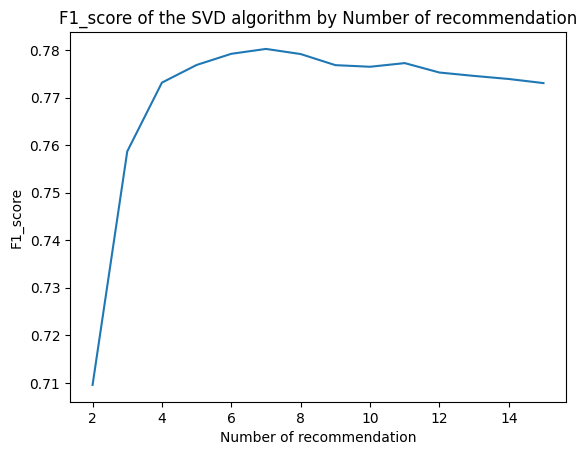

In [60]:
import matplotlib.pyplot as plt
k_array,prec_array,recall_array,f1_array=get_f1_data_k(algo_svd,7)
plt.plot(k_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Number of recommendation")
plt.title("F1_score of the SVD algorithm by Number of recommendation")

We observe that the F1_score is maximal with 7 books recommended and that it doesn' have a great variation as it's approximatively always 80% after 5 books recommended, so this parameter is not very important in our case. 7 is still a good value as we don't want to recommend too many books as a user usually consider only the first books recommended.

In [51]:
def get_f1_data_t(algo,k):
    r_array,prec_array,recall_array,f1_array=[],[],[],[]
    for r in np.arange(2,11):
        r_array.append(r)
        result=get_recall_precision_F1(algo,k,r)
        prec_array.append(result[0])
        recall_array.append(result[1])
        f1_array.append(result[2])
    return r_array,prec_array,recall_array,f1_array

Text(0.5, 1.0, 'F1_score of the SVD algorithm by rating threshold')

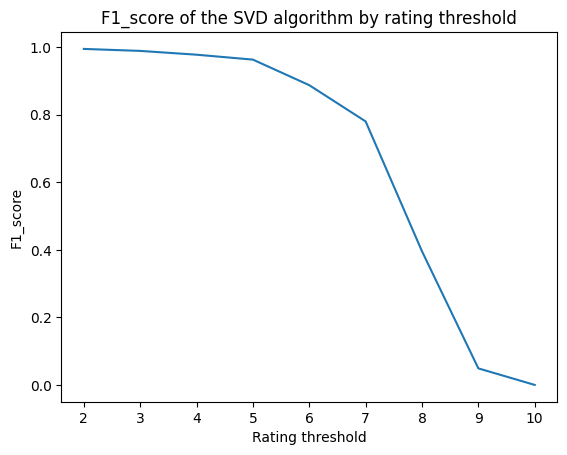

In [57]:
import matplotlib.pyplot as plt
r_array,prec_array,recall_array,f1_array=get_f1_data_t(algo_svd,7)
get_f1_data_t
plt.plot(r_array,f1_array)
plt.ylabel("F1_score")
plt.xlabel("Rating threshold")
plt.title("F1_score of the SVD algorithm by rating threshold")

We observe that the F1 score decrease with the increse of rating threshold wich is logical as more we are strict with the rating of the book to recommend more it'is difficult to respect the condition. The curve drop significantly after a threshold of 7. As book ratings of 5 and 6 are a little low to be recommended, We should use 7 as threshold even if a F1_score of 80% is a little low.

We get a precision of 80%, a recall of 82% and a F1 score of 80% which is average and coherent with the results obtained with the RMSE. This model is acceptable for our need but a better model can/should be found and it will be inacceptable in many field such as health.

This machine learning problem has shown us two limits of recommender system only done with python: limitation of memory and time of computation. 
It partly explain why the graph database are so often used in the domain of recommendation. With this kind of base it's much more easy to find similar item or user as the algorithm just need to go from node to node based on relationship and we don't store useless informationin the memory, only usefull one. 

Reference:

"Hands on recommendation systems with Python" by Rounak Banik 

"Graph-Powered Machine Learning" by Alessandro Negro

https://realpython.com/build-recommendation-engine-collaborative-filtering/

https://surprise.readthedocs.io/en/stable/FAQ.html